# Fase 2 Processo Seletivo: Iniciação Científica em IA multimodal na triagem de Raios-X

**Matheus Santos Sano | RA:222370**

## Import libraries

In [5]:
import torchxrayvision as xrv
from torchvision import transforms
import torch
import os
from read_xray_dicom import read_xray_dcm
import json
import matplotlib.pyplot as plt
import pydicom
import numpy as np

## Show DICOM files

Before carrying out the classification with TorchXRayVision, an initial visualization of the dataset is presented to help understand the structure and content of the data. As can be seen below, the dataset consists of DICOM chest X-ray images

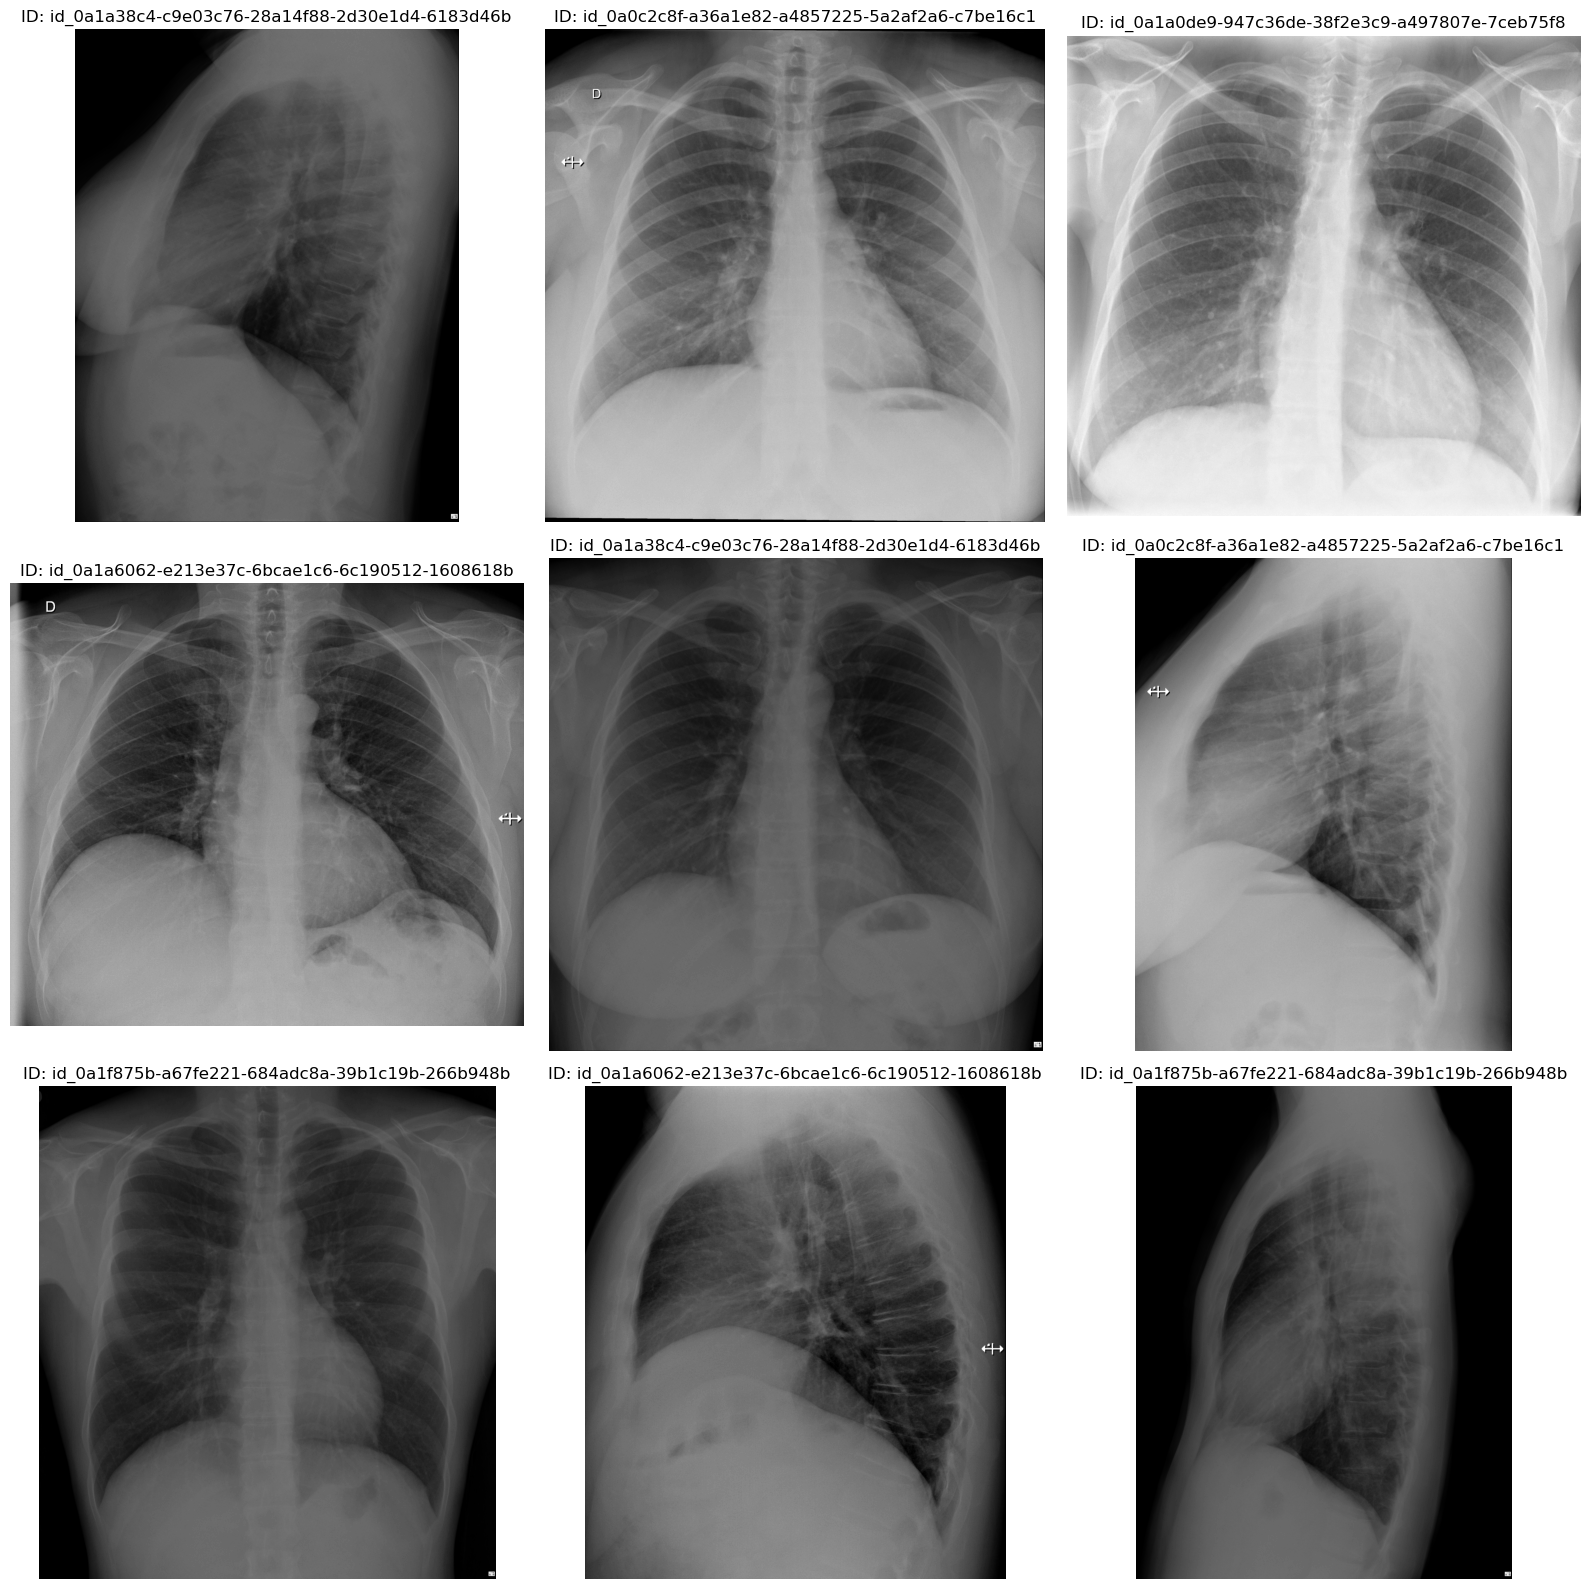

In [6]:
directory_images = 'dicom_samples'
files = os.listdir(directory_images)

# Display the DICOM images of the dataset
rows, cols = 3, 3
fig, axes = plt.subplots(rows, cols, figsize=(16, 16))
axes = axes.flatten()

for i, file in enumerate(files[:rows * cols]):
    dicom_path = os.path.join(directory_images, file)
    dicom_image = pydicom.dcmread(dicom_path)
    patient_id = dicom_image.get('PatientID')
    
    axes[i].imshow(dicom_image.pixel_array, cmap='gray')
    axes[i].set_title(f"ID: {patient_id}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Compute classification results using TorchXRayVision's DenseNet pre-trained model

To compute the classification of the findings from this dataset, a pre-trained model from TorchXRayVision is used. This library has pre-trained models such as DenseNet and ResNet. However, according to the paper [1], DenseNets proved to be the best architecture for predictive x-ray models. Therefore, DenseNet is used to perform the task.

[1]  [arxiv.org/abs/2002.02497](https://doi.org/10.48550/arXiv.2002.02497)

In [7]:
def classify_dicom_image(image):
    # To perform future transformations, the image must have a channel dimension, so the channel dimension (grayscale) is added
    image = image[None, ...]

    # Define and apply a series of transformations (crop the image around the center to get the most centered part
    # and resize the image to 224x224, which is the input size of DenseNet)
    transform = transforms.Compose([
        xrv.datasets.XRayCenterCrop(),
        xrv.datasets.XRayResizer(224)
    ])
    
    image_transformed = transform(image)

    # Transform the image into a tensor and add a dimension that corresponds to the batch_size (only 1 image in the batch)
    image_tensor = torch.from_numpy(image_transformed)
    image_tensor = image_tensor[None, ...]

    # Get predictions from a DesNet
    model = xrv.models.DenseNet(weights="densenet121-res224-all")
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)

    # Obtain the possible pathologies and their probabilities estimated by the model
    pathologies = model.pathologies
    probs_pathologies = outputs[0].detach().numpy()
    
    return dict(zip(pathologies, probs_pathologies.tolist()))

## Main

In [8]:
if __name__ == "__main__":
    
    directory_images = 'dicom_samples'
    for file in os.listdir(directory_images):
        
        # Loads the DICOM file and stores it in a 2D numpy
        image = read_xray_dcm(os.path.join(directory_images, file))
        
        # Execute classification with DenseNet
        result = classify_dicom_image(image)
        
        # Save predictions to a JSON file
        result_file = 'results_classification/' + os.path.splitext(file)[0] + '.json'
        with open(result_file, 'w') as json_file:
            json.dump(result, json_file)